# Preamble

In [1]:
from corals.threads import set_threads_for_external_libraries as set_threads
set_threads(1)

In [2]:
%load_ext watermark

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
np.show_config()

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib']
    include_dirs = ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib']
    include_dirs = ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
 

# Formulas

In [5]:
def a_exact(n, k):
    a = n / np.sqrt(k)
    return a

def a_optimal(n, k, r=1, positive=True):
    """
    TODO: fix, currently not working; some error in the formula
    """
    if positive:
        sign = 1
    else:
        sign = -1
    a = n * (1 + sign * np.sqrt(1 + r)) / np.sqrt(k)
    return a

def k_local(n, k, a):
    return a * k / n

def missed_values(a, n, k):
    return (np.sqrt(k) - a * k / n)**2

# Experiments

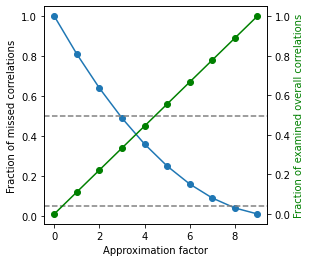

In [6]:
n = 32000
k = n**2 * 0.01
a = np.arange(0, a_exact(n, k))

n_missed = missed_values(a, n, k)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set(xlabel="Approximation factor")

ax.plot(a, n_missed / k)
ax.scatter(a, n_missed / k)
ax.set(ylabel="Fraction of missed correlations")

ax2 = ax.twinx()
# ax2.plot(a, k_local(n, k, a) * n / n**2, color="green")
# ax2.scatter(a, k_local(n, k, a) * n / n**2, color="green")
ax2.plot(a, k_local(n, k, a) * n / (k_local(n, k, a)[-1] * n), color="green")
ax2.scatter(a, k_local(n, k, a) * n / (k_local(n, k, a)[-1] * n), color="green")
ax2.set_ylabel("Fraction of examined overall correlations", color='green')
# n_missed, n_missed / k, a, 

# ax.axvline(0.5, linestyle="--", color="grey")
ax.axhline(0.5, linestyle="--", color="grey")
ax.axhline(0.05, linestyle="--", color="grey")

In [7]:
a_optimal(n, k, 0.01, positive=True), a_exact(n, k)

(20.04987562112089, 10.0)

# Check bounds

In [10]:
%load_ext rpy2.ipython

In [14]:
%%R -o corMatrix -o finalFeatures

"
In this example, we will generate a sample-feature matrix with 1000 samples and 1000 features where the top 10000 correlations are in a 100*100 block at the top-left corner of the correlation matrix

k = 10000
sqrt(k) = 100
n = 1000
k / n = 10
a = 1
bound = sqrt(k) * (sqrt(k) - a*k/n) = 9000
"

# This function adds random noise 10 times to 900 of the input feature's samples to make 10 distinct but highly-correlated features
perturb <- function(x) {
    sapply(1:10, function(y) x + c(rep(0, 100), rnorm(900, 0, 0.1)))
}

# Here we generate 10 features with 1000 samples such that the first 100 samples have identical measurements but the other 900 samples are random permutations. We then use the previous function to take each of these 10 features and generate 10 highly-correlated but distinct features, resulting in 100 features split into 10 moderately correlated blocks of 10 highly correlated features
genFeatures <- lapply(1:10, function(x) perturb(c(1:100, sample(101:200, 900, replace = T))))
genFeatures <- Reduce(cbind, genFeatures)

# Here we generate 900 features with 1000 samples which are essentially random noise
noiseFeatures <- sapply(1:900, function(x) sample(-200:200, 1000, replace = T))

# We put the previous two feature sets together and calculate the correlation matrix
finalFeatures <- cbind(genFeatures, noiseFeatures)
corMatrix <- cor(finalFeatures)

# Here you can see the distribution of top correlations. CorALS would get the top 10 correlations of each feature, which would be 1000 feature pairs of the top-left block of correlations and 9000 feature pairs involving the noisy, useless features. Hence, CorALS misses 9000 of the top-10000 correlations, which agrees with the bound described.

## Correlation distribution within each batch of highly-correlated generated features
sapply(1:10, function(x) {
    range <- seq(10 * x - 9, 10 * x)
    summary(c(corMatrix[range, range]))
})

## Correlation distribution between different batches of highly-correlated generated features
sapply(1:10, function(x) {
    range <- seq(10 * x - 9, 10 * x)
    summary(c(corMatrix[setdiff(1:100, range), range]))
})

## Correlation distribution between generated and noise features
summary(c(corMatrix[1:100, 101:1000]))

## Correlation distribution between noise features. Here, we take away the diagonal of 1's since these are trivial correlations to focus on the correlation between the noisy features themselves.
corMatrix <- corMatrix - diag(1000)
summary(c(corMatrix[101:1000, 101:1000]))

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1.387e-01 -2.130e-02 -4.190e-06 -2.643e-05  2.130e-02  1.594e-01 


<AxesSubplot:>

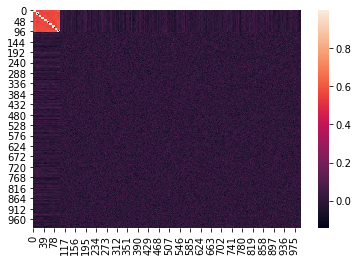

In [13]:
import seaborn as sns
sns.heatmap(corMatrix)

<AxesSubplot:>

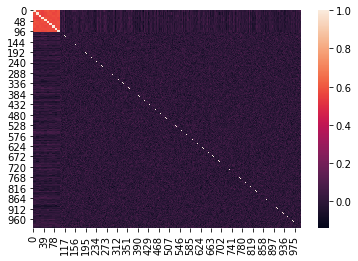

In [17]:
cor = np.corrcoef(finalFeatures.transpose())
sns.heatmap(cor)

In [18]:
from corals.correlation.topk import cor_topk

In [42]:
topk_cor, topk_idx = cor_topk(finalFeatures, approximation_factor=1, k=10000, symmetrize=False)

/home/mgbckr/mnt/nalab/workspaces/nalab-fastcor-final/lib-python/src/corals/correlation/topk/batched/base.py:136: UserWarning: Everything fit into one batch. Parallelization could be achieved using BLAS threading.
  warnings.warn(
/home/mgbckr/mnt/nalab/workspaces/nalab-fastcor-final/lib-python/src/corals/correlation/topk/batched/base.py:140: UserWarning: Everything fit into one batch. Make sure the approximation factor needs to be set for the current setup: 1.
  warnings.warn(


* prepare
* map
* reduce


In [63]:
def topk_custom(X, k=10000):
    # calculate correlation matrix
    cor = np.corrcoef(X.transpose())
    
    # list for results
    results = []
    
    # k searched for per feature
    kk = int(np.ceil(k / X.shape[1]))
    print("k'=",kk)
    
    # get top kk correlations per feature
    for i, row in enumerate(cor):
        idx_c = np.argsort(-np.abs(row))[:kk]
        results.extend([(i, j, row[j]) for j in idx_c])
        assert len(idx_c) == kk
    
    # get top-k correlations
    cors = [c for _,_,c in results]
    order = np.argsort(-np.abs(cors))
    results = [results[i] for i in order[:k]]
    
    return results

# test
result = topk_custom(finalFeatures)
c = np.array([c for _,_,c in result]) 
(c > 0.99).sum()

k'= 10


1900

# Watermark

In [8]:
%watermark

Last updated: 2022-09-21T04:31:23.881870-07:00

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.24.1

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-96-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 128
Architecture: 64bit



In [9]:
%watermark --iversions

matplotlib: 3.4.2
numpy     : 1.20.3

